<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))


Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [17]:
data = pd.read_csv('ner_dataset.csv',encoding='latin1')
data = data.fillna(method = 'ffill')
data.head(10)

Sentence #           Word  POS    Tag
0  Sentence: 1      Thousands  NNS      O
1  Sentence: 1             of   IN      O
2  Sentence: 1  demonstrators  NNS      O
3  Sentence: 1           have  VBP      O
4  Sentence: 1        marched  VBN      O
5  Sentence: 1        through   IN      O
6  Sentence: 1         London  NNP  B-geo
7  Sentence: 1             to   TO      O
8  Sentence: 1        protest   VB      O
9  Sentence: 1            the   DT      O

In [18]:
print(data['Word'].nunique())

35178


In [19]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
tags = list(set(data["Tag"].values))

In [20]:
class SentenceGetter(object):
    def __init__(self,data):
        self.n_sent= 1
        self.data = data
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                      s["POS"].values.tolist(),
                                                      s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        
        self.sentences = [s for s in self.grouped]
        
        

### Task 3: Retrieve Sentences and Corresponsing Tags

In [21]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [15]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [23]:
word2idx={w: i+1 for i, w in enumerate(words)}
tag2idx={t: i for i, t in enumerate(tags)}

In [25]:
tag2idx

{'B-art': 0,
 'B-eve': 1,
 'B-org': 2,
 'B-tim': 3,
 'I-eve': 4,
 'I-gpe': 5,
 'B-geo': 6,
 'I-per': 7,
 'I-art': 8,
 'I-nat': 9,
 'I-geo': 10,
 'I-org': 11,
 'B-gpe': 12,
 'B-per': 13,
 'B-nat': 14,
 'O': 15,
 'I-tim': 16}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

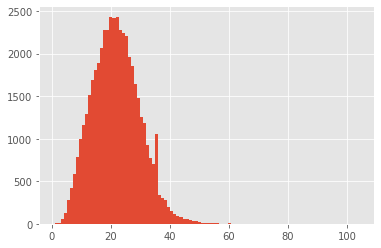

In [26]:
plt.hist([len(s) for s in sentences], bins = 100)
plt.show()

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

num_words = len(word2idx)
num_tags = len(tag2idx)
max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences (maxlen = max_len, sequences = X, padding="post",value=num_words-1)

y = [[tag2idx[w[2]]for w in s] for s in sentences]
y = pad_sequences (maxlen = max_len, sequences = y, padding="post",value=tag2idx["O"])
y = [to_categorical(i, num_classes = num_tags) for i in y]

In [28]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [29]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [31]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True,recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=['accuracy'])

### Task 7: Train the Model

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

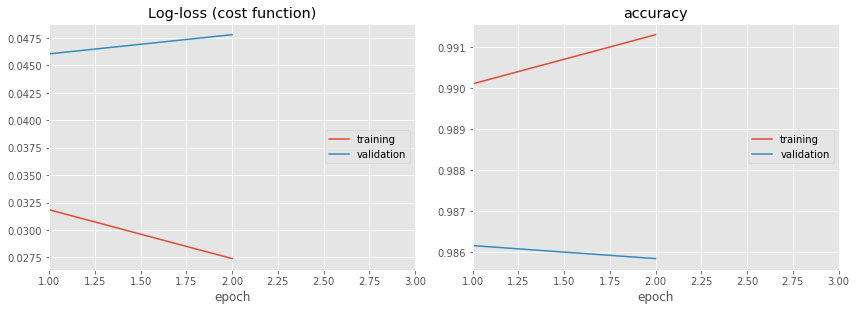

Log-loss (cost function):
training   (min:    0.027, max:    0.032, cur:    0.027)
validation (min:    0.046, max:    0.048, cur:    0.048)

accuracy:
training   (min:    0.990, max:    0.991, cur:    0.991)
validation (min:    0.986, max:    0.986, cur:    0.986)
34530/34530 [==============================] - 185s 5ms/sample - loss: 0.0274 - accuracy: 0.9913 - val_loss: 0.0478 - val_accuracy: 0.9858


In [35]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1, verbose=0, mode="max", restore_best_weights=False)
callbacks = [early_stopping,PlotLossesCallback()]
history = model.fit(
x_train,np.array(y_train),
    validation_split=0.2,
    batch_size= 32,
    epochs =3,
    verbose = 1,
    callbacks = callbacks
)

### Task 8: Evaluate Named Entity Recognition Model

In [36]:
model.evaluate(x_test,np.array(y_test))

4796/4796 [==============================] - 5s 1ms/sample - loss: 0.0488 - accuracy: 0.9857


[0.04884770667309359, 0.98570895]

In [38]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test),axis=-1)[i]
print("{:15}{:5}\t{}\n".format("word","true","pred"))
print("-"*30)
for w, true, pred in zip(x_test[i],y_true,p[0]):
    print("{:15}{}\t{}".format(words[w-1],tags[true],tags[pred]))

word           true 	pred

------------------------------
The            O	O
Sudanese       B-gpe	B-gpe
government     O	O
has            O	O
welcomed       O	O
the            O	O
Chinese        B-gpe	B-gpe
mission        O	O
to             O	O
Darfur         O	B-geo
.              O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian        O	O
Wannian   